In [1]:
import pandas as pd
from pandas_datareader import data, wb
import numpy as np
import requests
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<h1> Data Processing </h1>

In [2]:
url= "https://raw.githubusercontent.com/rohan-r-kulkarni/bigtech_randomforest/main/stockData.csv"
df = pd.read_csv(url)
df1=df.reset_index()
df1

,index,Unnamed: 0,META US Equity,META US Equity.1,META US Equity.2,META US Equity.3,META US Equity.4,META US Equity.5,META US Equity.6,META US Equity.7,...,SPX Index.1,SPX Index.2,SPX Index.3,SPX Index.4,SPX Index.5,SPX Index.6,SPX Index.7,SPX Index.8,SPX Index.9,SPX Index.10
0,0,NaN,1,2,3,4,5,6,7,8,...,2,3,4,5,6,7,8,9,10,11
1,1,Dates,PX_OPEN,PX_OFFICIAL_CLOSE,PE_RATIO,EV_EBITDA_ADJUSTED,SALES_GROWTH,CUR_MKT_CAP,PX_VOLUME,FREE_CASH_FLOW_YIELD,...,PX_OFFICIAL_CLOSE,PE_RATIO,EV_EBITDA_ADJUSTED,SALES_GROWTH,CUR_MKT_CAP,PX_VOLUME,FREE_CASH_FLOW_YIELD,PROF_MARGIN,EBITDA_TO_REVENUE,BEST_PX_SALES_RATIO
2,2,1/3/00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,28.1209,NaN,NaN,NaN,1071554100,2.99,7.61,NaN,NaN
3,3,1/4/00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,28.1744,NaN,NaN,NaN,1264023700,2.99,7.61,NaN,NaN
4,4,1/5/00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,28.2119,NaN,NaN,NaN,1177726200,2.98,7.61,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,11/28/22,109.54,109.46,10.3163,7.5916,-4.4674,290238.5179,23899238,8.7726,...,NaN,19.1332,NaN,NaN,34556774.68,517449991,4.95,11.17,NaN,2.2736
5978,5978,11/29/22,109.505,118.1,11.1306,7.5916,-4.4674,313147.8984,43348557,8.1308,...,NaN,19.7254,NaN,NaN,35624829.34,1406250061,4.8,11.17,NaN,2.343
5979,5979,11/30/22,119.198,120.44,11.3512,7.5916,-4.4674,319352.5223,36551374,7.9728,...,NaN,19.7083,NaN,NaN,35596739.87,633969105,4.8,11.17,NaN,2.3389
5980,5980,12/1/22,117.83,120.44,11.6386,7.5916,-4.4674,327439.7401,39685113,7.7759,...,NaN,19.6847,NaN,NaN,35596739.87,633969105,4.81,11.17,NaN,2.336


In [3]:
df2=df1.rename(columns={"Unnamed: 0": "Dates"})
dates=df2.loc[2:, "Dates"].reset_index(drop=True)
dates=pd.to_datetime(dates)

<h2> Get S&P 500 Price Series </h2>

In [4]:
spx_i = 5
spx_df = pd.DataFrame(df2.iloc[1: , 2+11*spx_i:].reset_index(drop=True))
spx_df.columns = spx_df.iloc[0, :]
#spx_df.columns = spx_df.loc[1, :]
spx_df = pd.DataFrame(spx_df.iloc[1:, 0]).reset_index(drop=True).dropna()
spx_df

,PX_OPEN
0,1455.22
1,1399.42
2,1402.11
3,1403.45
4,1441.47
...,...
5974,4005.36
5975,3964.19
5976,3957.18
5977,4087.14


<h2> Get Big Tech Stocks and Metrics </h2>

In [5]:
stocks = {}
drop = ["SALES_GROWTH", "PROF_MARGIN", "EBITDA_TO_REVENUE","EV_EBITDA_ADJUSTED"]
names = []

for i in range(0, 5):
    this_name = df2.columns[2+11*i].split(" ")[0]

    this_df = df2.iloc[1: , 2+11*i:13+11*i].reset_index(drop=True)
    this_df.columns = this_df.loc[0, :]
    this_df = this_df.drop(drop, axis = 1)
    this_df = this_df.loc[1:, :].reset_index(drop=True)
    this_df = pd.concat([dates, this_df], axis=1)

    this_df = this_df.reindex(['Dates', 'PX_OPEN', 'PE_RATIO', 'CUR_MKT_CAP',
        'PX_VOLUME', 'FREE_CASH_FLOW_YIELD', 'BEST_PX_SALES_RATIO','PX_OFFICIAL_CLOSE'],axis=1)
    
            
    this_df=this_df.set_index("Dates")
    this_df=this_df.astype(float)

    start_date = pd.to_datetime(this_df.index)[0]
    end_date = pd.to_datetime(this_df.index)[-1]
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    
    yf_data = yf.download(this_name, start=start_date, end=end_date)
    yf_data = yf_data.loc[:, ["High", "Low", "Adj Close"]]
    
    yf_data = yf_data.rename({"High": "HIGH", "Low":"LOW", "Adj Close": "ADJ_CLOSE"}, axis=1)
    
    this_df = this_df.join(yf_data)
    
    #price series shifts
    this_df['ADJ_CLOSE']=this_df['ADJ_CLOSE'].shift(-1) #move the ADJ_CLOSE to the correct date
    
    day_change = this_df.loc[:,"ADJ_CLOSE"] - this_df.loc[:,"PX_OPEN"] #close - open
    
    buy_indicator = (day_change>0).astype(int) #the actual y value (BUY or NOT BUY)
    this_df=this_df.assign(day_change=day_change)
    this_df=this_df.assign(buy_indicator=buy_indicator)

    if len(this_df) < 500: # do not include stocks with too small df
        continue 
    
    names.append(this_name)

    stocks[this_name] = this_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
stocks

{'META':             PX_OPEN  PE_RATIO  CUR_MKT_CAP   PX_VOLUME  FREE_CASH_FLOW_YIELD  \
 Dates                                                                          
 2000-01-03      NaN       NaN          NaN         NaN                   NaN   
 2000-01-04      NaN       NaN          NaN         NaN                   NaN   
 2000-01-05      NaN       NaN          NaN         NaN                   NaN   
 2000-01-06      NaN       NaN          NaN         NaN                   NaN   
 2000-01-07      NaN       NaN          NaN         NaN                   NaN   
 ...             ...       ...          ...         ...                   ...   
 2022-11-28  109.540   10.3163  290238.5179  23899238.0                8.7726   
 2022-11-29  109.505   11.1306  313147.8984  43348557.0                8.1308   
 2022-11-30  119.198   11.3512  319352.5223  36551374.0                7.9728   
 2022-12-01  117.830   11.6386  327439.7401  39685113.0                7.7759   
 2022-12-02      NaN

In [7]:
names

['META', 'GOOG', 'AMZN', 'NFLX', 'TSLA']

<h1> Implementing Technical Indicators </h1>

<h3>1. On-Balance Volume (OBV) </h3>

In [8]:
def calc_obv(x):
    if x.ADJ_CLOSE > x.prev_close:
        return x.prev_vol + x.PX_VOLUME
    elif x.ADJ_CLOSE < x.prev_close:
        return x.prev_vol - x.PX_VOLUME
    else:
        return x.prev_vol

In [9]:
def get_obv(s):
    obv = stocks[s].copy().loc[:, ["PX_VOLUME", "ADJ_CLOSE"]]
    obv=obv.assign(prev_close=obv.loc[:, "ADJ_CLOSE"].shift(1))
    vols=obv.loc[:, "PX_VOLUME"].shift(1)
    vols.values[0] = 0
    obv=obv.assign(prev_vol=vols)
    OBV_FIN=obv.apply(calc_obv, axis=1)
    obv=obv.assign(OBV_FIN=OBV_FIN)
    obv=obv.assign(close_change = obv.ADJ_CLOSE-obv.prev_close)
    obv=obv.assign(volume_change = obv.PX_VOLUME-obv.prev_vol)
    obv_indicator = ((obv.OBV_FIN.diff() > 0) & (obv.close_change > 0)).astype(int).shift(1)

    stocks[s]=stocks[s].assign(OBV_indicator=obv_indicator)

<h3>2. Bollinger Band </h3>

In [10]:
def get_bollinger(s):
    boll_df = stocks[s].copy()
    #Set number of days and standard deviations to use for rolling lookback period for Bollinger band calculation
    window = 10
    no_of_std = 2
    #Calculate rolling mean and standard deviation using number of days set above
    rolling_mean = boll_df['ADJ_CLOSE'].rolling(window).mean()
    rolling_std = boll_df['ADJ_CLOSE'].rolling(window).std()
    #create two new DataFrame columns to hold values of upper and lower Bollinger bands
    boll_df['Rolling Mean'] = rolling_mean
    boll_df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
    boll_df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)
    boll_indicator = ((boll_df.ADJ_CLOSE > 0) & (boll_df['Bollinger Low'] > 0)).astype(int).shift(1)
    boll_df=boll_df.assign(Position=boll_indicator)
    
    stocks[s]=stocks[s].assign(Bollinger_indicator=boll_indicator)

In [11]:
def plot_bollinger(boll_df):
    #Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
    #forward through time
    boll_df['Position'].fillna(method='ffill',inplace=True)
    #Calculate the daily market return and multiply that by the position to determine strategy returns
    boll_df['Market Return'] = np.log(boll_df['ADJ_CLOSE'] / boll_df['ADJ_CLOSE'].shift(1))
    boll_df['Strategy Return'] = boll_df['Market Return'] * boll_df['Position'].shift(1)
    #Plot the strategy returns
    boll_df[['Strategy Return','Market Return']].cumsum().plot()

<h3>3. (Exponential) Moving Average Convergence/Divergence (MACD) </h3>

In [12]:
def get_macd(s):
    ema_12=stocks[s].loc[:, "ADJ_CLOSE"].ewm(min_periods=12, com=12-1).mean()
    ema_26=stocks[s].loc[:, "ADJ_CLOSE"].ewm(min_periods=26, com=26-1).mean()
    macd = ema_12-ema_26
    signal_line=macd.ewm(min_periods=9, com=9-1).mean()

    macd_indicator = ((macd > signal_line)).astype(int).shift(1)
    
    stocks[s]=stocks[s].assign(MACD_indicator=macd_indicator)

<h3>4. Volume Weighted Average Price (VWAP)</h3>

In [13]:
def calc_vwap(x):
    return (x.cum_tp * x.PX_VOLUME)/(x.cum_vol)

In [14]:
def get_vwap(s):
    vwap_df=stocks[s].copy().loc[:, ["HIGH", "LOW", "ADJ_CLOSE", "PX_VOLUME"]]
    typ_price=vwap_df.loc[:, ["HIGH", "LOW", "ADJ_CLOSE"]].mean(axis=1)
    vol = vwap_df.loc[:, ["PX_VOLUME"]]
    cum_tp = typ_price.cumsum()
    cum_vol=vol.cumsum()
    vwap_df = vwap_df.assign(cum_tp=cum_tp)
    vwap_df = vwap_df.assign(cum_vol=cum_vol)
    vwap_df=vwap_df.assign(VWAP=vwap_df.apply(calc_vwap, axis=1))
    vwap_indicator = ((vwap_df.ADJ_CLOSE < vwap_df.VWAP)).astype(int).shift(1)
    vwap_df=vwap_df.assign(VWAP_indicator=vwap_indicator)

    stocks[s]=stocks[s].assign(VWAP_indicator=vwap_indicator)    

<h3>5. Relative Strength Index (RSI) </h3>

In [15]:
def calc_rsi(df, periods = 14, ema = True):
    #ema: exponential moving average (good lag indicators for stocks)
    #     not predictive of future prices; they simply highlight the trend that is being followed by the stock price
    
    close_delta = df['ADJ_CLOSE'].diff()
    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))

    return rsi

In [16]:
def get_rsi(s):
    rsi_df=stocks[s].copy()
    rsi_df['RSI'] = calc_rsi(rsi_df, periods = 7, ema = True)
    # Threshold for RSI: 30 < buy, 70 > sell
    min_size=50
    max_size=60
    rsi_indicator = ((rsi_df['RSI'] > max_size)).astype(int).shift(1)
    rsi_df=rsi_df.assign(RSI_buy_indicator=rsi_indicator)

    stocks[s]=stocks[s].assign(RSI_indicator=rsi_indicator)

In [17]:
def plot_rsi(rsi_df):
    #Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
    #forward through time
    rsi_df['RSI_buy_indicator'].fillna(method='ffill',inplace=True)
    #Calculate the daily market return and multiply that by the position to determine strategy returns
    rsi_df['Market Return'] = np.log(rsi_df['ADJ_CLOSE'] / rsi_df['ADJ_CLOSE'].shift(1))
    rsi_df['Strategy Return'] = rsi_df['Market Return'] * rsi_df['RSI_buy_indicator'].shift(1)
    #Plot the strategy returns
    rsi_df[['Strategy Return','Market Return']].cumsum().plot()

<h3>5. Money Flow Index (MFI) </h3>

In [18]:
def gain(x):
    return ((x > 0) * x).sum()

def loss(x):
    return ((x < 0) * x).sum()

# Calculate money flow index
def calc_mfi(high, low, close, volume, n=14):
    typical_price = (high + low + close)/3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()

In [19]:
def get_mfi(s):
    mfi_df=stocks[s].copy()
    mfi_df['MFI'] = calc_mfi(mfi_df['HIGH'], mfi_df['LOW'], mfi_df['PX_OFFICIAL_CLOSE'], mfi_df['PX_VOLUME'], 14)
    mfi_indicator = ((mfi_df['MFI'] > 60)).astype(int).shift(1)
    mfi_df=mfi_df.assign(MFI_buy_indicator=mfi_indicator)

    stocks[s]=stocks[s].assign(MFI_indicator=mfi_indicator)

<h1> Build Independent/Dependent Variables For Each Stock </h1>

In [20]:
stock_x = {} #independent variables DataFrame by stock
stock_y = {} #dependent variable Series by stock

In [21]:
for stock in names:
    get_obv(stock)
    get_bollinger(stock)
    get_macd(stock)
    get_vwap(stock)
    get_rsi(stock)
    get_mfi(stock)
    
    #get indepdendent variables
    x = stocks[stock][['OBV_indicator','Bollinger_indicator',
                    'MACD_indicator', 'VWAP_indicator',
                    'RSI_indicator', 'MFI_indicator'
                  ]]

    #get dependent variable
    y = stocks[stock]['buy_indicator']
    
    x = x.dropna()
    y = y[1:]

    stock_x[stock] = x
    stock_y[stock] = y

<h1> Build Training/Testing Sets and Models </h1>

In [22]:
sgd_models = {} #SGD models and train/test sets by stock
rf_models = {} #Random forest models and train/test sets by stock
nn_models = {} #Neural Network models and train/test sets by stock

In [23]:
def build_sgd_model(s):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import SGDClassifier
    
    X = stock_x[s]
    Y = stock_y[s]

    #Get x_train, x_test, y_train, y_test
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, train_size = 0.7, random_state=42)

    clf = SGDClassifier(random_state=42,max_iter=1000,loss="log") 
    clf.fit(x_train,y_train) 

    sgd_models[s] = [clf, x_train, x_test, y_train, y_test]  

In [24]:
#Grid Search for Optimal Random Forest Hyperparameters

# from sklearn.model_selection import GridSearchCV
# parameters = { #Parameters are for the random forest classifier model
#      'n_estimators':(10, 20), #the number of trees
#      'max_depth':(6,10), #The maximum depth of any tree
#      'min_samples_split': (10,), #The minimum samples in a node for a split to occur
#      'min_samples_leaf': (8,), #The minimum samples in a leaf node (nodes with fewer samples will be discarded)
# }

# #For grid search, we'll use 3 fold CV, and use all available processors in parallel (n_jobs=-1)
# gs_clf = GridSearchCV(RandomForestClassifier(),parameters,cv=3,n_jobs=-1)
# gs_clf.fit(x_train, np.ravel(y_train))
# gs_clf.best_score_, gs_clf.best_params_ #Best score is the mean CV score of the best estimator (model)

In [25]:
#Hyperparameter Choice from Grid Search

# (0.7369175627240144,
#  {'max_depth': 10,
#   'min_samples_leaf': 8,
#   'min_samples_split': 10,
#   'n_estimators': 10})

In [26]:
def build_random_forest_model(s):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    
    X = stock_x[s]
    Y = stock_y[s]

    #Get x_train, x_test, y_train, y_test
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, train_size = 0.7, random_state=42)
    
    
    rf = RandomForestClassifier(random_state=42,n_estimators=10,max_depth=10,min_samples_leaf=8,min_samples_split=10)
    rf.fit(x_train,y_train.astype(int))
    
    rf_models[s] = [rf, x_train, x_test, y_train, y_test]   

In [27]:
def build_neural_network_model(s):
    from sklearn.model_selection import train_test_split
    from sklearn.neural_network import MLPClassifier

    X = stock_x[s]
    Y = stock_y[s]

    #Get x_train, x_test, y_train, y_test
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, train_size = 0.7, random_state=42)
    
    nn = MLPClassifier(solver="adam",hidden_layer_sizes=(40,), max_iter = 2000, 
                    activation='relu',
                    learning_rate='constant',random_state=42
                   )
    nn.fit(x_train,y_train)

    nn_models[s] = [nn, x_train, x_test, y_train, y_test]  

In [28]:
for stock in names:
    build_sgd_model(stock)
    build_random_forest_model(stock)
    build_neural_network_model(stock)

<h1> Run Models and Obtain Results </h1>

In [29]:
col_names = ["Training Accuracy", "Testing Accuracy", "Precision", "Recall", "F1 Score", "AUC", "AP"]
stock_names = names
model_names = ["SGD Classifier", "Random Forest", "Neural Network"]
multi_index=pd.MultiIndex.from_product([stock_names, model_names],
                           names=['Stock', 'Model'])
results_df = pd.DataFrame(np.zeros((len(multi_index),len(col_names))))
results_df.index = multi_index
results_df.columns = col_names

In [30]:
def run_model(model_info):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import f1_score,recall_score,precision_score
    from sklearn.metrics import average_precision_score,roc_auc_score
    
    model, x_train, x_test, y_train, y_test = model_info
    
    predictions = model.predict(x_test)

    cfm = confusion_matrix(y_test,predictions)
    accuracy_training = model.score(x_train,y_train)
    accuracy_testing = model.score(x_test,y_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    y_prob = model.predict_proba(x_test)[:,1]
    auc = roc_auc_score(y_test, y_prob)
    ap = average_precision_score(y_test, predictions)
    
    metrics = [accuracy_training, accuracy_testing, precision, recall, f1, auc, ap]
    
    return metrics

In [31]:
def stock_results(s):
    sgd_res = run_model(sgd_models[s])
    rf_res = run_model(rf_models[s])
    nn_res = run_model(nn_models[s])
    
    results_df.loc[[s], :] = np.stack((sgd_res, rf_res, nn_res))

In [32]:
for stock in names:
    stock_results(stock)

In [33]:
results_df

Training Accuracy  Testing Accuracy  Precision  \
Stock Model                                                            
META  SGD Classifier           0.764875          0.775920   0.426829   
      Random Forest            0.783035          0.803233   0.569288   
      Neural Network           0.787575          0.795987   0.536364   
GOOG  SGD Classifier           0.810036          0.804905   0.452514   
      Random Forest            0.821983          0.810479   0.475524   
      Neural Network           0.819594          0.804905   0.449704   
AMZN  SGD Classifier           0.514217          0.517837   0.498542   
      Random Forest            0.534050          0.520067   0.502573   
      Neural Network           0.529988          0.512263   0.490534   
NFLX  SGD Classifier           0.529988          0.561315   0.486626   
      Random Forest            0.583513          0.562430   0.470732   
      Neural Network           0.583990          0.561873   0.458472   
TSLA  SGD Classifier           0.736440          0.751394   0.560345   
      Random Forest            0.753405          0.745819   0.508621   
      Neural Network           0.749343          0.735229   0.467249   

                        Recall  F1 Score       AUC        AP  
Stock Model                                                   
META  SGD Classifier  0.089744  0.148305  0.817320  0.236187  
      Random Forest   0.389744  0.462709  0.834345  0.354541  
      Neural Network  0.453846  0.491667  0.831120  0.362156  
GOOG  SGD Classifier  0.243243  0.316406  0.788326  0.250539  
      Random Forest   0.204204  0.285714  0.812063  0.244819  
      Neural Network  0.228228  0.302789  0.810332  0.245890  
AMZN  SGD Classifier  0.197917  0.283347  0.516810  0.484957  
      Random Forest   0.339120  0.404976  0.507822  0.488716  
      Neural Network  0.329861  0.394464  0.506549  0.484550  
NFLX  SGD Classifier  0.621551  0.545874  0.598847  0.462997  
      Random Forest   0.253614  0.329633  0.585219  0.435995  
      Neural Network  0.181340  0.259887  0.582504  0.430408  
TSLA  SGD Classifier  0.141304  0.225694  0.792474  0.299358  
      Random Forest   0.256522  0.341040  0.794141  0.321108  
      Neural Network  0.232609  0.310595  0.789531  0.305453

<h1> Visualize Results </h1>

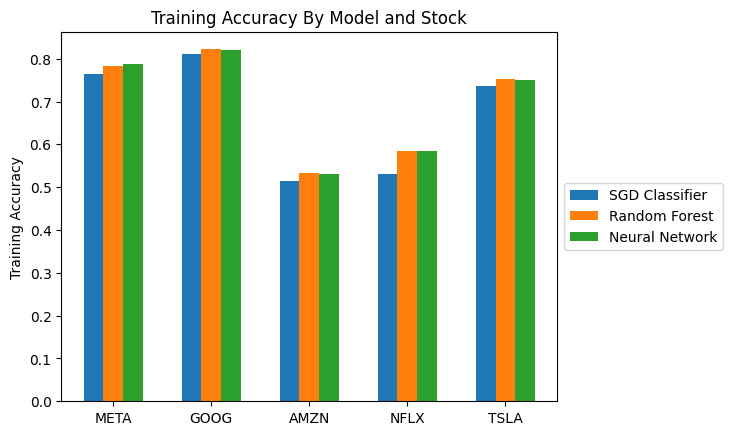

In [34]:
#Training Accuracy

plot_df=results_df.loc[:, ["Training Accuracy"]].reset_index()
labels = names
sgd_vals = plot_df.loc[plot_df.Model=="SGD Classifier", "Training Accuracy"].values
rf_vals = plot_df.loc[plot_df.Model=="Random Forest", "Training Accuracy"].values
nn_vals = plot_df.loc[plot_df.Model=="Neural Network", "Training Accuracy"].values

x = np.arange(0, 1.5*len(labels), 1.5)  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, sgd_vals, width, label='SGD Classifier')
rects2 = ax.bar(x, rf_vals, width, label='Random Forest')
rects3 = ax.bar(x + width, nn_vals, width, label='Neural Network')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Training Accuracy")
ax.set_title('Training Accuracy By Model and Stock')
ax.set_xticks(x, labels)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

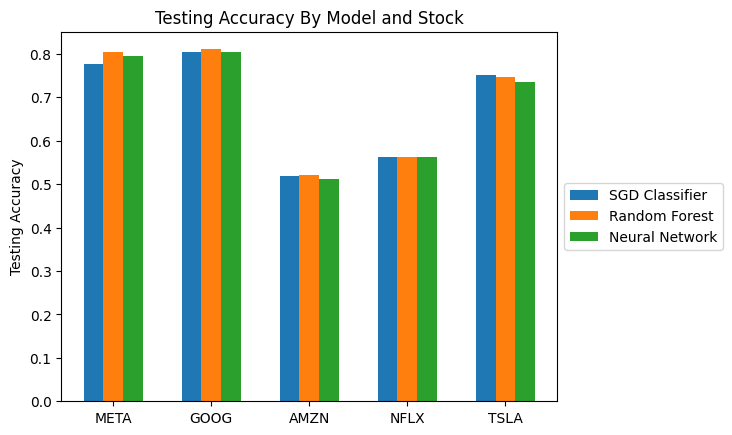

In [35]:
#Testing Accuracy

plot_df=results_df.loc[:, ["Testing Accuracy"]].reset_index()
labels = names
sgd_vals = plot_df.loc[plot_df.Model=="SGD Classifier", "Testing Accuracy"].values
rf_vals = plot_df.loc[plot_df.Model=="Random Forest", "Testing Accuracy"].values
nn_vals = plot_df.loc[plot_df.Model=="Neural Network", "Testing Accuracy"].values

x = np.arange(0, 1.5*len(labels), 1.5)  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, sgd_vals, width, label='SGD Classifier')
rects2 = ax.bar(x, rf_vals, width, label='Random Forest')
rects3 = ax.bar(x + width, nn_vals, width, label='Neural Network')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Testing Accuracy')
ax.set_title('Testing Accuracy By Model and Stock')
ax.set_xticks(x, labels)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

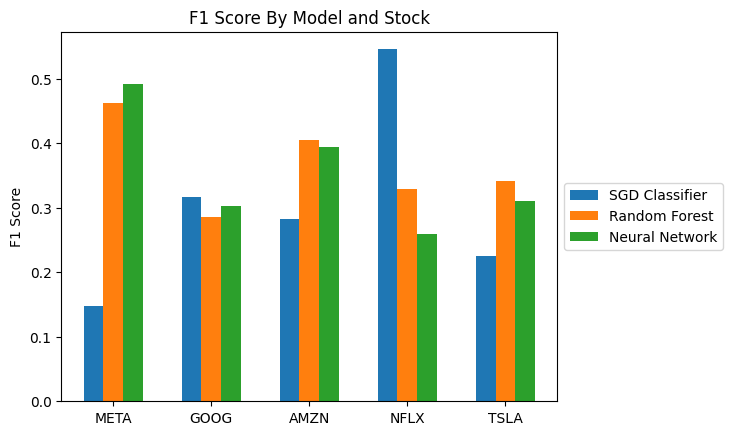

In [36]:
#F1 Score

plot_df=results_df.loc[:, ["F1 Score"]].reset_index()
labels = names
sgd_vals = plot_df.loc[plot_df.Model=="SGD Classifier", "F1 Score"].values
rf_vals = plot_df.loc[plot_df.Model=="Random Forest", "F1 Score"].values
nn_vals = plot_df.loc[plot_df.Model=="Neural Network", "F1 Score"].values

x = np.arange(0, 1.5*len(labels), 1.5)  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, sgd_vals, width, label='SGD Classifier')
rects2 = ax.bar(x, rf_vals, width, label='Random Forest')
rects3 = ax.bar(x + width, nn_vals, width, label='Neural Network')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score By Model and Stock')
ax.set_xticks(x, labels)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

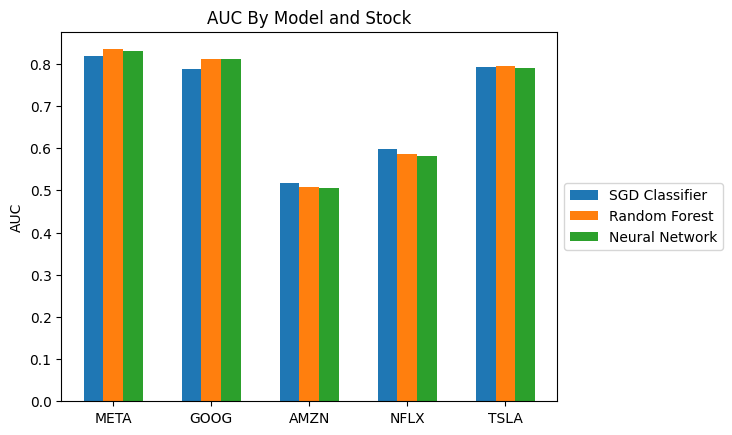

In [37]:
#AUC

plot_df=results_df.loc[:, ["AUC"]].reset_index()
labels = names
sgd_vals = plot_df.loc[plot_df.Model=="SGD Classifier", "AUC"].values
rf_vals = plot_df.loc[plot_df.Model=="Random Forest", "AUC"].values
nn_vals = plot_df.loc[plot_df.Model=="Neural Network", "AUC"].values

x = np.arange(0, 1.5*len(labels), 1.5)  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, sgd_vals, width, label='SGD Classifier')
rects2 = ax.bar(x, rf_vals, width, label='Random Forest')
rects3 = ax.bar(x + width, nn_vals, width, label='Neural Network')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC')
ax.set_title('AUC By Model and Stock')
ax.set_xticks(x, labels)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

<h1> Feature Importance </h1>

In [38]:
names

['META', 'GOOG', 'AMZN', 'NFLX', 'TSLA']

In [39]:
from sklearn.ensemble import RandomForestRegressor
rf_model_beta = RandomForestRegressor(max_depth=5)

tech_indicators = np.array(["OBV", "Bollinger", "MACD", "VWAP", "RSI", "MFI"])

stock_featimp = {}

for stock in names:
    
    print(stock + ":")
    
    x_train, x_test, y_train, y_test  = rf_models[stock][1:]
    
    rf_model_beta.fit(x_train,y_train)    
    importances = rf_model_beta.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    feat_labels = tech_indicators

    for f in range(len(tech_indicators)):
        print("%2d) %-*s %f" % (f + 1, 30,
                                feat_labels[sorted_indices[f]],
                                importances[sorted_indices[f]]))
    print()

    stock_featimp[stock] = [importances, sorted_indices]

META:
 1) Bollinger                      0.553697
 2) MACD                           0.246963
 3) OBV                            0.111979
 4) RSI                            0.048759
 5) VWAP                           0.023343
 6) MFI                            0.015260

GOOG:
 1) VWAP                           0.523819
 2) OBV                            0.270154
 3) MFI                            0.093164
 4) Bollinger                      0.049681
 5) MACD                           0.033534
 6) RSI                            0.029649

AMZN:
 1) Bollinger                      0.206877
 2) MFI                            0.200994
 3) MACD                           0.182545
 4) OBV                            0.155529
 5) RSI                            0.147815
 6) VWAP                           0.106241

NFLX:
 1) MACD                           0.284902
 2) OBV                            0.222687
 3) Bollinger                      0.214114
 4) RSI                            0.122502
 5) V

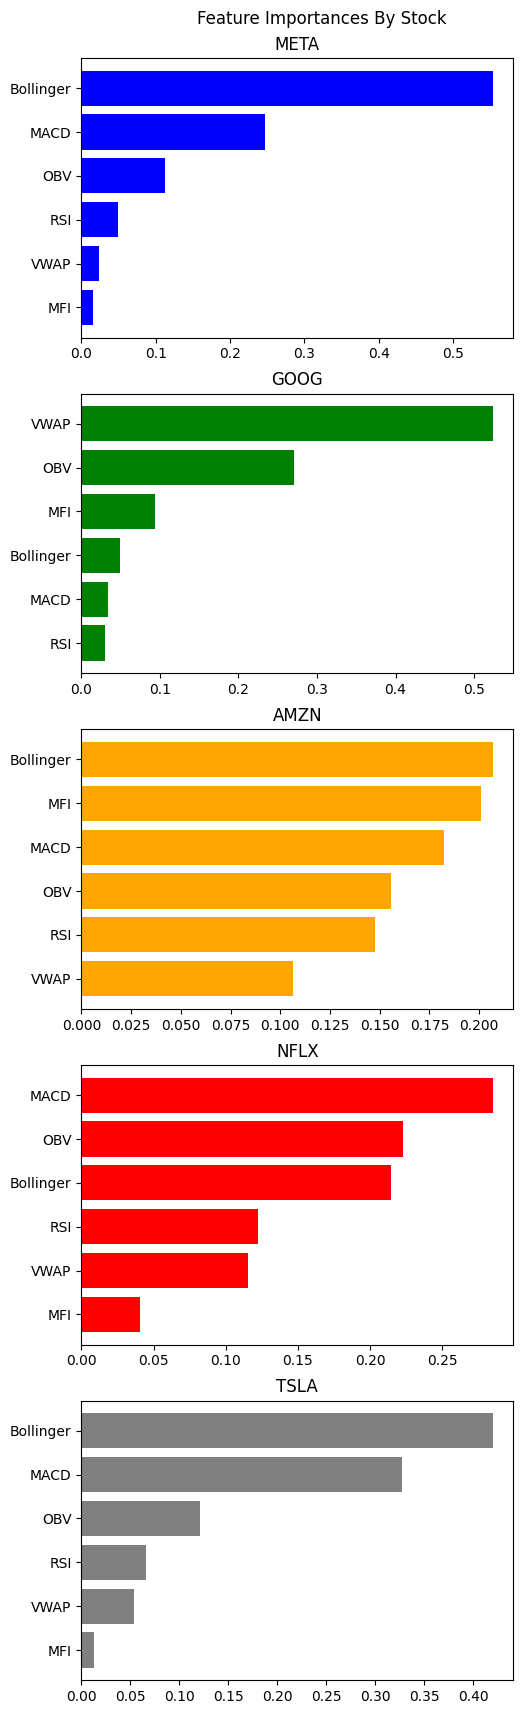

In [40]:
import matplotlib.pyplot as plt

colors = ["blue", "green", "orange", "red", "gray"]

fig, ax = plt.subplots(5)
fig.suptitle("Feature Importances By Stock")

fig.subplots_adjust(bottom=-2.5, right=0.8)

i=0
for stock in names:
    
    ax[i].set_title(stock)
    
    this_importance = stock_featimp[stock][0]
    this_sorted = stock_featimp[stock][1]
    this_sorted = np.flip(np.array(this_sorted))
        
    ax[i].barh(range(len(tech_indicators)), this_importance[this_sorted], align='center', color = colors[i])
    ax[i].set_yticks(range(len(tech_indicators)), tech_indicators[this_sorted])
        
    i+=1

plt.show()